# Adversarial Attack

In [0]:
import numpy as np
from PIL import Image
import json


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import torchvision.transforms as transforms

import torchvision.utils
import torchvision
from torchvision import models
import torchvision.datasets as dsets

import matplotlib.pyplot as plt

## 1. Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

model = models.resnet152(pretrained=True)
#model = wget("https://download.pytorch.org/models/resnet152-b121ed2d.pth")
#model.eval()
#print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
torch.cuda.is_available()

True

In [5]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
idx = json.load(open('/content/drive/My Drive/imagenet_samples/imagenet_classes.json'))
idx2class = [idx[str(i)] for i in range(len(idx))]

In [0]:
transform = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
    #transforms.RandomCrop(112)
])

In [0]:
def image_pre(root, transform, custom_label) :
    
    data = dsets.ImageFolder(root, transform)
    class2idx = {}
    
    for i, item in enumerate(idx2class) :
        class2idx[item] = i
    
    new_data = dsets.ImageFolder(root, transform, 
                                 target_transform = lambda x : custom_label.index(data.classes[x]))
    new_data.classes = idx2class
    new_data.class2idx = class2idx

    return new_data

In [0]:
pre_data = image_pre(root = '/content/drive/My Drive/imagenet_samples/', transform = transform, custom_label=idx2class)
pre_loader = Data.DataLoader(pre_data, batch_size=1, shuffle=False)

In [0]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (3, 9))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

Clean Image


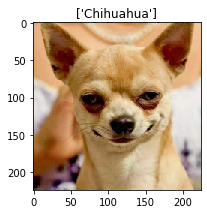

In [0]:
clean_iter = iter(pre_loader)
images, labels = clean_iter.next()

print("Clean Image")
imshow(torchvision.utils.make_grid(images, normalize=True), [pre_data.classes[i] for i in labels])

In [0]:
def gaus(x): #gaussian blur func with std=0.1
    x = x.squeeze()
    x1 = x.cpu()
    x1 = x1.detach().numpy()
    x1 = x1.astype('float32')
    noise = np.random.normal(loc= 0, scale= 0.05, size=np.shape(x1))
    noise = noise.astype('float32')
    
    x1 = x1 + noise
    x2 = torch.from_numpy(x1)
    x2 = x2.unsqueeze(0)
    #print(x2.dtype)
    return x2

Gaussian Blur Image


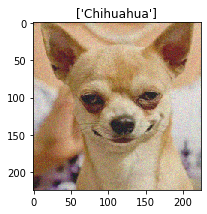

In [0]:
clean_iter = iter(pre_loader)
images, labels = clean_iter.next()

images = gaus(images)

print("Gaussian Blur Image")
imshow(torchvision.utils.make_grid(images, normalize=True), [pre_data.classes[i] for i in labels])

(Before Attack) Predicted Label


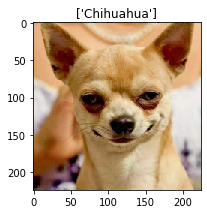

Confidence :99.72 %


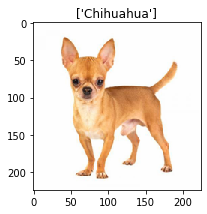

Confidence :99.88 %


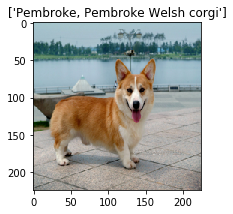

Confidence :98.26 %


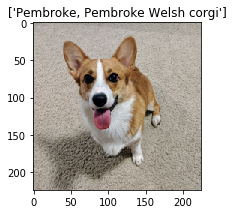

Confidence :97.63 %


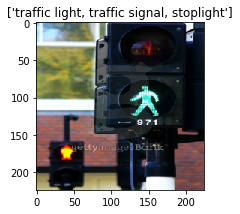

Confidence :47.62 %


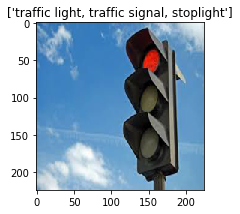

Confidence :95.77 %
Accuracy: 100.000000 %


In [0]:
print("(Before Attack) Predicted Label")

model.eval()

cnt = 0
total = 0

for images, labels in pre_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)

    cnt += (pre == labels).sum()
    total += 1

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
        
print('Accuracy: %f %%' % (100 * float(cnt) / total))

# 2. Attack method 

# 2.1 FGSM

In [0]:
def fgsm_attack(model,images,labels,eps) :
    
    images = images.to(device)
    images.requires_grad = True
    outputs = model(images)
    
    model.zero_grad()
    cost = nn.CrossEntropyLoss()(outputs, labels)
    cost = cost.to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    #attack_images = torch.clamp(attack_images, 0, 1) #clip(0,1)
    
    return attack_images

(FGSM Attack) Predicted Label


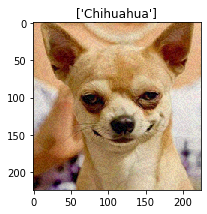

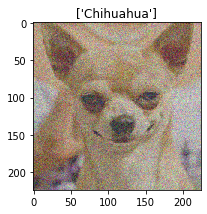

Confidence :63.11 %
Confidence :99.84 %


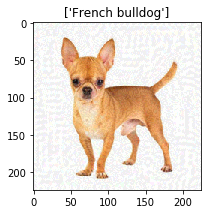

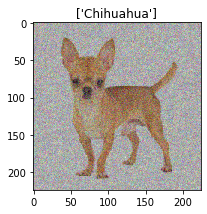

Confidence :98.65 %
Confidence :99.80 %


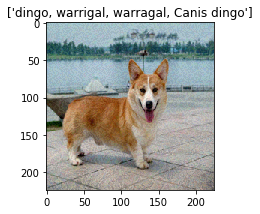

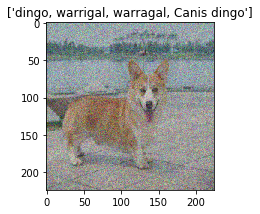

Confidence :67.29 %
Confidence :86.19 %


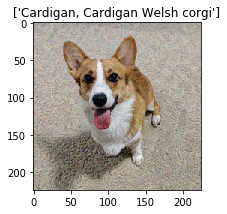

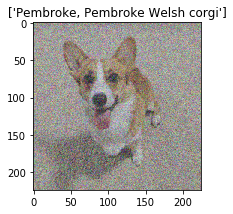

Confidence :21.45 %
Confidence :69.03 %


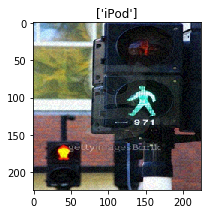

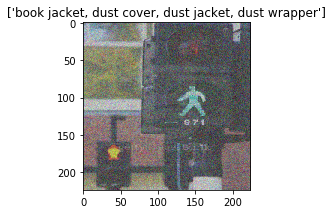

Confidence :73.86 %
Confidence :15.88 %


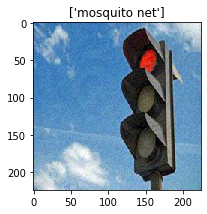

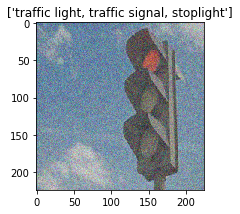

Confidence :42.61 %
Confidence :80.21 %
Accuracy of test text: 16.666667 %
Accuracy of test text: 66.666667 %


In [0]:
print("(FGSM Attack) Predicted Label")
model.eval()

cnt = 0
cnt2 = 0
total = 0

for images, labels in pre_loader:
    labels = labels.to(device)
    images = fgsm_attack(model, images, labels, 0.03).to(device)
    
    t_img = gaus(images)
    t_img = t_img.to(device)

    outputs = model(images)
    t_out = model(t_img)
    _, pre = torch.max(outputs.data, 1)
    _, t_pre = torch.max(t_out.data, 1)

    cnt += (pre == labels).sum()
    cnt2 += (t_pre == labels).sum()
    total += 1
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    imshow(torchvision.utils.make_grid(t_img.cpu().data, normalize=True), [pre_data.classes[i] for i in t_pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(t_out).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(cnt) / total))
print('Accuracy of test text: %f %%' % (100 * float(cnt2) / total))

# 2.2 PGD

In [0]:
def pgd_attack(model, images, labels, eps, alpha, iters) :
    images = images.to(device)
    labels = labels.to(device)
        
    last_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = nn.CrossEntropyLoss()(outputs, labels)
        cost = cost.to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - last_images, min=-eps, max=eps)
        images = torch.clamp(last_images + eta, min=0, max=1).detach_()
            
    return images

(PGD Attack) Predicted Label


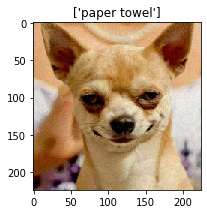

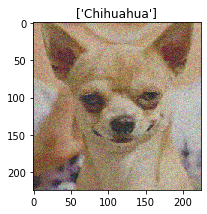

Confidence :100.00 %
Confidence :99.86 %


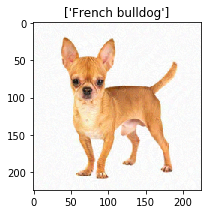

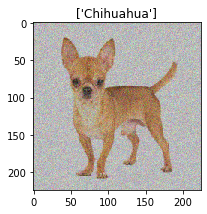

Confidence :99.96 %
Confidence :98.81 %


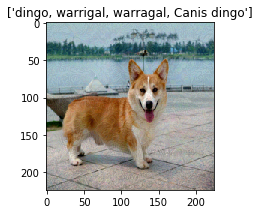

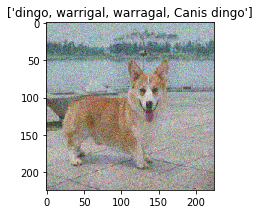

Confidence :100.00 %
Confidence :96.98 %


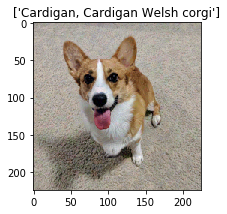

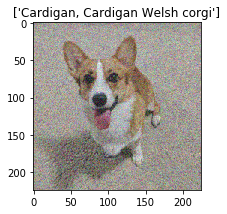

Confidence :100.00 %
Confidence :50.66 %


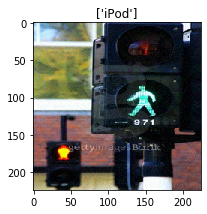

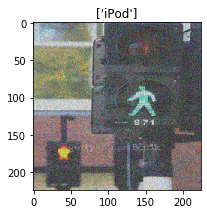

Confidence :100.00 %
Confidence :68.76 %


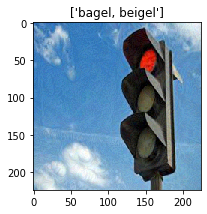

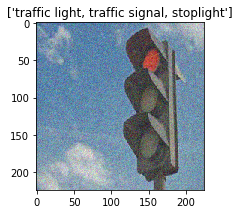

Confidence :100.00 %
Confidence :77.68 %
Accuracy: 0.000000 %
Accuracy: 50.000000 %


In [16]:
print("(PGD Attack) Predicted Label")

model.eval()

cnt = 0
cnt2 = 0 
total = 0

for images, labels in pre_loader:
    
    images = pgd_attack(model, images, labels, 0.03, 2/255, 40)
    labels = labels.to(device)

    t_img = gaus(images)
    t_img = t_img.to(device)
    
    outputs = model(images)
    t_out = model(t_img)
    _, pre = torch.max(outputs.data, 1)
    _, t_pre = torch.max(t_out.data, 1)

    cnt += (pre == labels).sum()
    cnt2 += (t_pre == labels).sum()
    total += 1

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    imshow(torchvision.utils.make_grid(t_img.cpu().data, normalize=True), [pre_data.classes[i] for i in t_pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(t_out).max()*100).item())
    
print('Accuracy: %f %%' % (100 * float(cnt) / total))
print('Accuracy: %f %%' % (100 * float(cnt2) / total))

In [0]:
# pgd with l2 norm

def norms(x):
    return x.view(x.shape[0], -1).norm(dim=1)[:None,None,None]

def pgd2_attack(model, images,labels, eps, alpha, iters) :
    
    images = images.to(device)
    ori_images = images.data

    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images).to(device)
    
        cost = nn.CrossEntropyLoss()(outputs,labels)
        cost = cost.to(device)
        cost.backward()

        adv_images = images + ( (alpha * images.grad) / norms(images.grad) )
        #adv_images = torch.min( torch.max(adv_images,-images),1-images )
        adv_images = (eps * adv_images) / norms(adv_images).clamp(min=eps)
        adv_images = adv_images.detach_()
            
    return adv_images

(PGD L2 Attack) Predicted Label


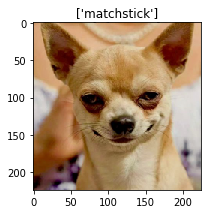

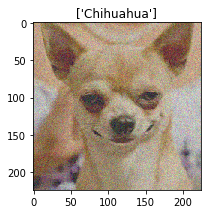

Confidence :2.27 %
Confidence :99.98 %


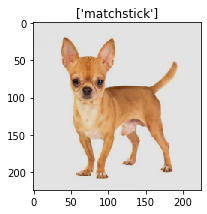

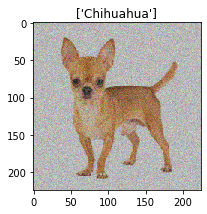

Confidence :2.27 %
Confidence :99.94 %


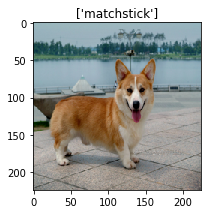

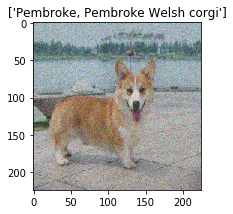

Confidence :2.27 %
Confidence :97.03 %


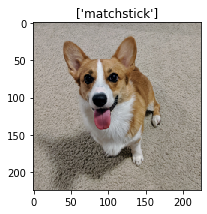

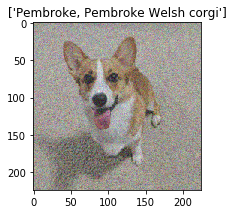

Confidence :2.27 %
Confidence :95.57 %


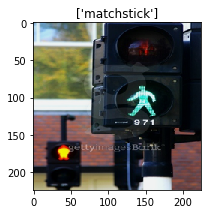

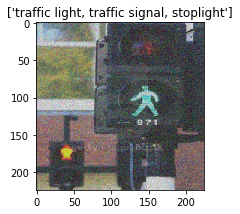

Confidence :2.27 %
Confidence :81.21 %


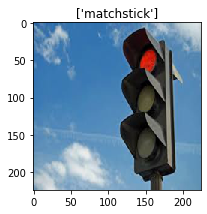

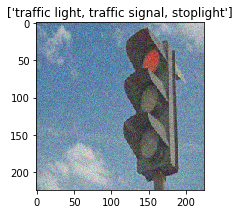

Confidence :2.27 %
Confidence :99.50 %
Accuracy: 0.000000 %
Accuracy: 100.000000 %


In [74]:
print("(PGD L2 Attack) Predicted Label")

model.eval()

cnt = 0
cnt2 = 0 
total = 0

for images, labels in pre_loader:

    labels = labels.to(device)
    ori_img = images
    ori_img = ori_img.to(device)
    images = pgd2_attack(model, images, labels, 0.03, 2/255, 40)
    
    tr_img = ori_img + (gaus(images).to(device)-images)
    #print(images.dtype)
    #print(tr_img.dtype)
    
    outputs = model(images)
    t_out = model(tr_img)
    _, pre = torch.max(outputs.data, 1)
    _, t_pre = torch.max(t_out.data, 1)

    cnt += (pre == labels).sum()
    cnt2 += (t_pre == labels).sum()
    total += 1

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    imshow(torchvision.utils.make_grid(tr_img.cpu().data, normalize=True), [pre_data.classes[i] for i in t_pre])
    #imshow(torchvision.utils.make_grid( (images.cpu() - tr_img.cpu()).data, normalize=True), [pre_data.classes[i] for i in t_pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(t_out).max()*100).item())
    
print('Accuracy: %f %%' % (100 * float(cnt) / total))
print('Accuracy: %f %%' % (100 * float(cnt2) / total))

# 2.3 Least Likely Attack

In [0]:
def ll_class_attack(model, loss, images, scale, eps, alpha, iters=0) :
    images = images.to(device)    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
        
    clamp_max = 224
    
    if iters == 0 :
        iters = int(min(eps + 4, 1.25*eps))
        
    if scale :
        eps = eps / 224
        clamp_max = clamp_max / 224
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images - alpha*images.grad.sign()

        x1 = torch.clamp(images - eps, min=0)
        x2 = (attack_images>=x1).float()*attack_images + (x1>attack_images).float()*x1
        x3 = (x2 > images+eps).float()*(images+eps) + (images+eps >= x2).float()*x2
        images = torch.clamp(x3, max=clamp_max).detach_()
    
    return images

(LL Attack) Predicted Label


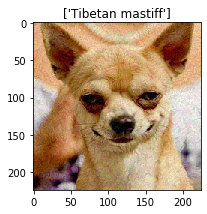

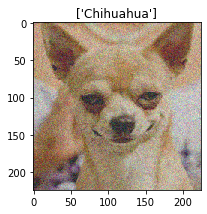

Confidence :96.22 %
Confidence :95.99 %


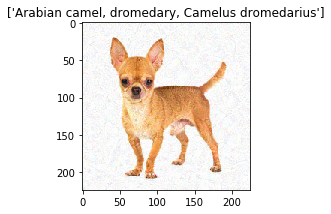

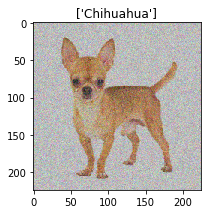

Confidence :18.41 %
Confidence :99.20 %


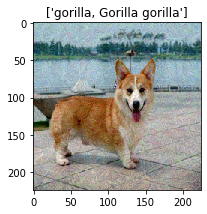

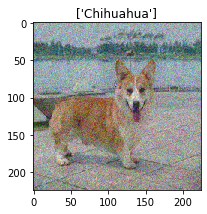

Confidence :96.16 %
Confidence :58.52 %


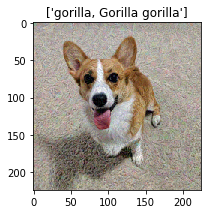

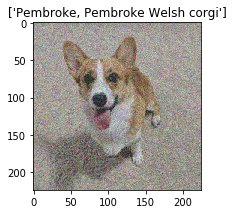

Confidence :51.62 %
Confidence :67.79 %


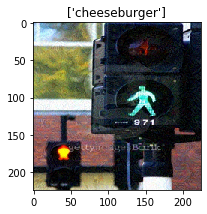

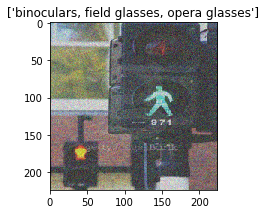

Confidence :98.74 %
Confidence :7.72 %


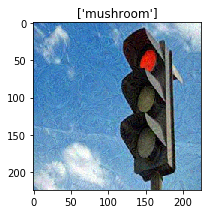

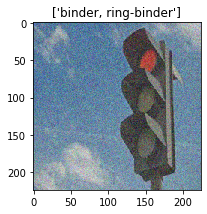

Confidence :31.20 %
Confidence :16.10 %
Accuracy1: 0.000000 %
Accuracy2: 50.000000 %


In [43]:
loss = nn.CrossEntropyLoss()
print("(LL Attack) Predicted Label")

model.eval()

correct = 0
correct2 = 0
total = 0

for images, labels in pre_loader:
    
    images = ll_class_attack(model, loss, images, 1, 4, 1).to(device)
    labels = labels.to(device)

    #print(images.dtype)
    t_img = gaus(images)
    t_img = t_img.to(device)

    outputs = model(images)
    t_out = model(t_img)
    
    _, pre = torch.max(outputs.data, 1)
    _, t_pre = torch.max(t_out.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    correct2 += (t_pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    imshow(torchvision.utils.make_grid(t_img.cpu().data, normalize=True), [pre_data.classes[i] for i in t_pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(t_out).max()*100).item())
    
print('Accuracy1: %f %%' % (100 * float(correct) / total))
print('Accuracy2: %f %%' % (100 * float(correct2) / total))

In [0]:
def gaus(x):
    x = x.squeeze()
    x1 = x.cpu()
    x1 = x1.detach().numpy()
    x1 = x1.astype('float32')
    noise = np.random.normal(loc= 0, scale= 0.1, size=np.shape(x1))
    noise = noise.astype('float32')
    
    x1 = x1 + noise
    x2 = torch.from_numpy(x1)
    x2 = x2.unsqueeze(0)
    #print(x2.dtype)
    return x2

In [0]:
def gausn(x):
    x = x.squeeze()
    x1 = x.cpu()
    x1 = x1.detach().numpy()
    x1 = x1.astype('float32')
    noise = np.random.normal(loc = x1.mean(), scale= 0.001, size=np.shape(x1))
    noise = noise.astype('float32')
    
    x1 = noise
    x2 = torch.from_numpy(x1)
    x2 = x2.unsqueeze(0)
    #print(x2.dtype)
    return x2

In [0]:
import skimage as ski
from skimage import io, color
from skimage import data

In [0]:
def toLab(x):
    x = x.squeeze() # 1x3x224x224 -> 3x224x224
    x1 = x.cpu()
    x1 = x1.detach().numpy()
    x1 = np.transpose(x1,(1,2,0)) #transpose 3x224x224(cxy) -> 224x224x3 (xyc)
    #print(x1.size())
    x1 = color.rgb2lab(x1)
    x1 = np.transpose(x1,(2,0,1)) # 224x224x3 (xyc) -> 3x224x224 (cxy)
    x1 = x1.astype('float32')
    x2 = torch.from_numpy(x1)
    x2 = torch.unsqueeze(x2,0)
    #print(x2.size)
    return x2

def fromLab(x):
    x = x.squeeze() # 1x3x224x224 -> 3x224x224
    x1 = x.cpu()
    x1 = x1.detach().numpy()
    x1 = np.transpose(x1,(1,2,0)) #transpose 3x224x224(cxy) -> 224x224x3 (xyc)
    #print(x1.size())
    x1 = color.lab2rgb(x1)
    x1 = np.transpose(x1,(2,0,1)) # 224x224x3 (xyc) -> 3x224x224 (cxy)
    x1 = x1.astype('float32')
    x2 = torch.from_numpy(x1)
    x2 = torch.unsqueeze(x2,0)
    return x2

def relaxed_loss(images,labels,t_func):
    outputs = model(images).to(device) # y' = model(t(x'))
    loss = nn.CrossEntropyLoss()(outputs,labels) 
    loss = loss.to(device)
    return loss

In [0]:
# lambda = 0.1, alpha=5 , iter=40 
# how to determine proper lambda?

# expectation over estimation with PGD 
def eot_attack(model, images, labels, eps, alpha, iters,t_func) :
    
    images = images.to(device)
    ori_img = images
       
    for i in range(iters) :
        loss = 0
        grad = 0
        for i in range(30) :
          adv_img = t_func(images).to(device)  #t(x')
          adv_img.requires_grad = True

          model.zero_grad()
          loss += relaxed_loss(adv_img,labels,t_func)
          #tmp = adv_img.grad.cpu()
          #grad += tmp

        loss /= 30
        #grad /= 30
        loss.backward()

        # loss = logP(y'|t(x')) - lambda * ||Lab(t(x'))-Lab(t(x))||_2
        adv_img = toLab(adv_img).to(device) + alpha * toLab(adv_img.grad).to(device) / norms( toLab(adv_img.grad).to(device) )
        adv_img *= eps / norms( adv_img - toLab(ori_img).to(device)).clamp(min=eps)
        adv_img = fromLab(adv_img)
        adv_img = adv_img.detach()
        adv_img = adv_img.to(device)
            
    return adv_img

(EOT Attack with Gaussian) Predicted Label


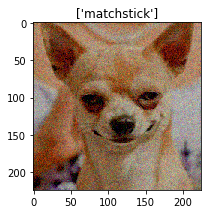

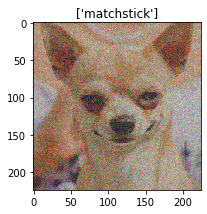

Confidence :2.27 %
Confidence :2.27 %


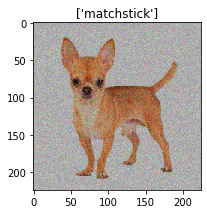

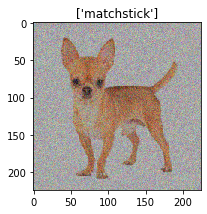

Confidence :2.27 %
Confidence :2.27 %


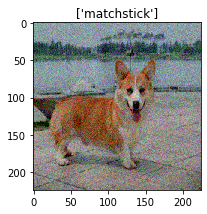

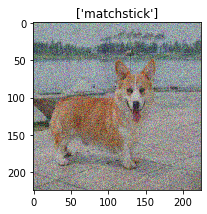

Confidence :2.27 %
Confidence :2.27 %


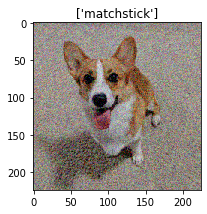

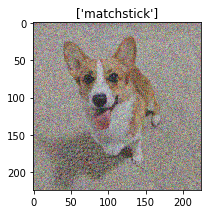

Confidence :2.27 %
Confidence :2.27 %


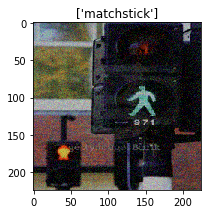

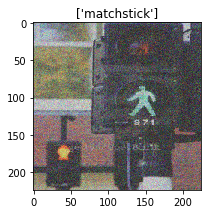

Confidence :2.26 %
Confidence :2.26 %


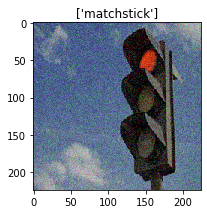

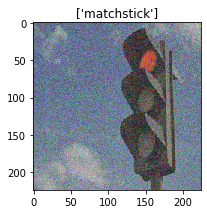

Confidence :2.27 %
Confidence :2.27 %
Accuracy: 0.000000 %
Accuracy2: 0.000000 %


In [78]:
print("(EOT Attack with Gaussian) Predicted Label")

model.eval()
cnt = 0
cnt2 = 0
total = 0

for images, labels in pre_loader:

    labels = labels.to(device)
    img = eot_attack(model, images,labels, 2, 0.1, 40,gaus).to(device)

    t_img = img + (gaus(img).to(device)-img)*0.0005

    outputs = model(img)
    t_out = model(t_img)
    _, pre = torch.max(outputs.data, 1)
    _, t_pre = torch.max(t_out.data, 1)

    cnt += (pre == labels).sum()
    cnt2 += (t_pre == labels).sum()
    total += 1
    
    imshow(torchvision.utils.make_grid(img.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    imshow(torchvision.utils.make_grid(t_img.cpu().data, normalize=True), [pre_data.classes[i] for i in t_pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(t_out).max()*100).item())
    
print('Accuracy: %f %%' % (100 * float(cnt) / total))
print('Accuracy2: %f %%' % (100 * float(cnt2) / total))